### Electric Vehicle Charging Station Placement Agent-Based Model
Julia Caravias \
November 2022

In [26]:
#Import Packages
import networkx as nx
import mesa 
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

from Model_World2 import *

#### Define EV and charging station agent classes

In [2]:
class EVAgent(mesa.Agent): 
    """ EVAgent objects represent electric vehicles which move with the model graph and may be in either a charging or driving state """ 
    
    def __init__(self, unique_id, model, inital_loc, trips, trip_lengths): 
        super().__init__(unique_id, model) 
        self.soc = 100 #state of charge, initalized to 100%
        self.amount_charged = 0 #sum of SOC that has been increased for this vehicle over the entire simulation
        self.elec_charge_price = 0 #sum of electricity price for charging vehicle 
    
        
        self.loc = inital_loc #inital node location
        self.trips = trips #list of nodes to travel to
        self.trip_lengths = trip_lengths #list of how long to stay at each node 
        self.current_trip_length = trip_lengths[0] #how many ticks to stay at current node
        
        self.on_trip = True #indicator for being in driving state
        self.trip_start = 0 #tick when trip begins
        
        self.current_charger_objs = []  #list of all the chargers at the current node
        self.in_queue = False
        self.plugged_in = False #indicator for having been assigend a charger and charging
        self.charging = False #indicator for being in parked state
        self.charging_start = None #tick when charging begins 
        self.charger_used = None #the assigned charger object when charging
        
        self.trips_completed = 0
        self.no_charge_count = 0
        
    
    def take_trip(self): 
        """ This function executes the trip (driving) state. When a EV agent has been in the trip state for the length of the trip, complete the trip."""
            
        if self.model._current_tick - self.trip_start >= self.model.G.get_edge_data(self.loc,self.trips[0])["weight"]: 
            #if enough ticks have passed to complete trip (given by edge weight) 
            if flag:
                print("*****") 
                print("trip complete")
                print("drive distance", self.model.G.get_edge_data(self.loc,self.trips[0])["weight"])
                print("trip_list" , self.trips)
                print("trip_length", self.trip_lengths)
                print("current trip length", self.current_trip_length)
                print("*****") 
            
            self.on_trip = False
            
            #update attributes for completed trip    
            self.soc -= (self.model.G.get_edge_data(self.loc,self.trips[0])["weight"] * 20) / 420 * 100
            self.trips_completed += 1
            self.loc = self.trips[0] #update location for new node
            self.current_trip_length = self.trip_lengths[0]
            self.trips = self.trips[1:]
            self.trip_lengths = self.trip_lengths[1:]
            self.model.grid.move_agent(self, self.loc)  #update position on grid 
   
            #switch to charging state
            self.charging = True
            self.charging_start = self.model._current_tick
            
    def increase_charge(self):
        """ Called each tick when a vehicle is charging
            updates SOC and total amount charged based on charger speed
            updates cost of charging """ 
        
        #determine rate based on charger type 
        if self.charger_used.charger_type == "fast": 
            charge_per_tick = self.model.fast_charging_rate
        elif self.charger_used.charger_type == "slow": 
            charge_per_tick = self.model.slow_charging_rate 
        elif self.charger_used.charger_type == "home":
            charge_per_tick = self.model.home_charging_rate 

        #increase soc by charge_per_tick unless fully charged 
        temp = self.soc
        self.soc = min(self.soc + charge_per_tick, 100) #dont allow charge above 100% 
        self.amount_charged += self.soc - temp
        
        #update cost of charging 
        if self.charger_used.charger_type == "slow": 
            self.elec_charge_price += self.model.elec_price * 2.75 #5.5 KW charger for a slow charger, so for each tick 3.7 KW energy is used
        if self.charger_used.charger_type == "fast": 
            self.elec_charge_price += self.model.elec_price * 11 #50 KW charger for a fast charger, so for each tick 11 KW energy is used
        if self.charger_used.charger_type == "home": 
            self.elec_charge_price += self.model.elec_price * 0.65 #1.3 KW charger for a home charger, so for each tick 11 KW energy is used
            
    def charge(self): 
        """ This function executes the charging state. EV agents in this state may either charge and occupy a charger, or if all chargers are in use then it will 
        wait in the queue at that node"""
        
        try:
            self.current_charger_objs = self.model.charger_loc[self.loc]
        except: 
            self.current_charger_objs = []  
        
        if self.current_charger_objs != []: #if there are one or more chargers at this location
            for charger in self.current_charger_objs: #iterate through chargers at this node
                if self.model.charger_queue[self.loc] == [] or self.plugged_in: #if there are no cars in the queue
                    if charger.car_charging == None or charger.car_charging == self.unique_id: #if no other cars at this charger
                        #begin charging
                        self.charger_used = charger
                        charger.car_charging = self.unique_id #state that this car is at the given charger
                        self.plugged_in = True 
                        
                        self.increase_charge() #increase charge
                        break
                
                #if there is a queue at the charger, check if you are first in line. if first, then remove from queue and start charging. if not dont charge
                else: #there is a queue
                    if self.model.charger_queue[self.loc][0] == self.unique_id: #if you are first in line
                        if charger.car_charging == None: #no other cars occupying this charger
                            #begin charging
                            self.model.charger_queue[self.loc] = self.model.charger_queue[self.loc][1:] #remove yourself from queue 
                            self.in_queue = False
                            charger.car_charging = self.unique_id #start charging
                            self.plugged_in = True
                            self.charger_used = charger
                            break
                
            
            #if after interating through all the chargers you have not been assigned a charger, add yourself to queue
            if not self.plugged_in: 
                if self.unique_id not in self.model.charger_queue[self.loc]: #if not already in queue
                    self.model.charger_queue[self.loc].append(self.unique_id) 
                    self.in_queue = True

        #Leaving the charging station
        if self.model._current_tick - self.charging_start >= self.current_trip_length: # if have been at charging station for trip length
            #begin trip if you have sufficient charge for the next edge 
            if self.soc > (self.model.G.get_edge_data(self.loc,self.trips[0])["weight"] * 200) / 420 * 100: 
                self.charging = False
                self.plugged_in = False
                self.on_trip = True #switch to trip
                if self.charger_used != None: #if EV agent was occupying a charger, leave
                    self.charger_used.car_charging = None 
                    
                if self.in_queue: #if EV agent was in the queue, leave
                    self.model.charger_queue[self.loc] = [i for i in self.model.charger_queue[self.loc] if i != self.unique_id]  
                    self.in_queue = False
                
                self.trip_start = self.model._current_tick #update tick in which trip begins
                
            else: #do not have enough charge to begin the next trip, stay in charging state 
                self.charging = True
                self.no_charge_count += 1
                
        
    def step(self):     
        if self.charging: 
            self.charge()
        if self.on_trip: 
            self.take_trip()
        
        if flag: 
            print("\n")
            print("EV number",self.unique_id)
            print("Location", self.loc)
            print("car soc", self.soc)
            print("trip list", self.trips) 
            print("trip lenghts", self.trip_lengths)
            print("plugged in", self.plugged_in) 
            print("charging", self.charging)
            print("on trip", self.on_trip)
        


In [3]:
class Charger(mesa.Model): 
    """  Charger objects track the cars at the given station""" 
    
    def __init__(self,unique_id, model,node_loc, charger_type): 
        super().__init__(unique_id, model)
        self.unique_id = unique_id
        self.node_loc = node_loc
        self.car_charging = None
        self.charger_type = charger_type #fast, slow or home
             
    def step(self): 
        pass

#### Define EVCS model class 

In [130]:
class EVCSModel(mesa.Model): 
    """ EV Charging Station Model uses an agent based approach. EV agent and chargers are placed throughout a graph defined by Model_World.py 
    
    EV agents move between nodes in the network according to a randomly generated "trip list". At each node, EV agents may charge if a charger is present 
    that is not in use by another agent. If the charger is in use, then the EV agent joins the charger queue at that node.
    
    Time steps is discretized in the model by defined "ticks", where 1 tick = 30 minutes. EV agents execute charging, waiting in the queue,
    or travel at each time step. 
    
    Key data about EV movements is collected. 

    """ 
    def __init__(self, no_agents,individual, no_ticks, G, trip_lists, percent_fast, charge_rates, scenario, day_ahead_df):
        self.ticks = no_ticks
        self._current_tick = 0
        
        self.no_agents = no_agents
        self.no_chargers = sum(individual) 
        
        self.no_fast = math.floor(percent_fast * self.no_chargers)
        
        self.fast_charging_rate = charge_rates[0]
        self.slow_charging_rate = charge_rates[1]
        self.home_charging_rate = charge_rates[2]
        self.scenario = scenario
        
        
        ### implemented to convert individual input from GA algo into dictionary format of charger placement 
        charger_placement = {}
        for i in range(len(individual)):
            charger_placement[i] = individual[i]
            
        # print(charger_placement) 
            
            
        self.agents = []
        self.chargers = []
        self.charger_dict = {} 
        self.charger_queue = {} #key = node, value = list of car id's in queue at that node
        self.charger_loc = {} #key = node, value = charger id at that node 
        
        self.schedule = mesa.time.BaseScheduler(self)
        self.elec_price = float(day_ahead_df[day_ahead_df['tick'] == self._current_tick]["Price KWh"]) #price is given as euro/KWh
        
        self.G = G
        self.grid = NetworkGrid(self.G)
            
        self.datacollector = DataCollector(model_reporters={'Average Charge Level': get_average_soc,
                                                            'Average EV Trips Complete': get_trips_completed, 
                                                            "Amount Charged": get_amount_charged, 
                                                           "Instances of Insufficient Charge": get_insufficient_charge_count, 
                                                           "Length of Queue": get_number_in_queue, 
                                                           "Electricity cost (euro)": get_elec_cost, 
                                                           "Total cost": get_total_cost, 
                                                           "Utility": get_utility,
                                                           "Agent Loc": get_agent_loc})
        
        #Generate EV agents 
        for i in range(self.no_agents): 
            a = EVAgent(unique_id = i, model =self, inital_loc = trip_lists[i][0][0], trips = trip_lists[i][0][1:], trip_lengths = trip_lists[i][1][1:])
            self.grid.place_agent(a, i)
            self.agents.append(a)
            self.schedule.add(a)
            
        #Determine the random assignment of fast chargers among nodes that have a charger at them
        charger_nodes = [i for i in charger_placement.keys() if charger_placement[i] == 1]
        
#         print("******")
#         print(charger_nodes, "charger nodes")
#         print("numnber fast", self.no_fast)
        fast_charger_nodes = random.sample(charger_nodes, k = self.no_fast)
        # print(fast_charger_nodes)
        
#         if self.scenario == 1: 
#             total_fast = 0
#             fast_charger_nodes = []
#             while total_fast < self.no_fast: 

#                 node = random.sample(all_nodes[self.no_agents:], k = 1)[0] #randomly sample the unique ID for fast chargers
#                 if charger_placement[node] + total_fast <= self.no_fast:
#                     if charger_placement[node] != 0 and node not in fast_charger_nodes: 
#                         fast_charger_nodes.append(node)
#                         total_fast += charger_placement[node]
            
#         else: #sceanario 2 
#             total_fast = 0
#             fast_charger_nodes = []
#             while total_fast < self.no_fast: 
#                 print("count", count)
#                 count += 1
#                 node = random.sample(range(self.G.number_of_nodes()), k = 1)[0]
#                 if charger_placement[node] + total_fast <= self.no_fast:
#                     if charger_placement[node] != 0: 
#                         fast_charger_nodes.append(node)
#                         total_fast += charger_placement[node]
            
#         fast_count = 0
     
        
        charger_unique_id = [k for k in range(self.no_chargers)]
            
        for i in range(self.G.number_of_nodes()):   
            if charger_placement[i] == 0: #skip if there are no chargers at this node
                continue
            
            #if self.scenario == 1: #assignment of charger types according to scenario 1
            if i < self.no_agents:
                charger_type = "home"
            elif i in fast_charger_nodes: #and fast_count < self.no_fast:
                #for non-home chargers, randomly assign fast nodes
                charger_type = "fast"
                #fast_count += 1 
            else: 
                charger_type = "slow"
                    
            # else: #assignment of charger types according to scenario 2
            #     if i in fast_charger_nodes: # and fast_count < self.no_fast: 
            #         charger_type = "fast"
            #         #fast_count += 1
            #     else: 
            #         charger_type = "slow"
            
            #Generate charger agents and queue 
            for j in range(charger_placement[i]): #for each charger j placed at node i 
                c = Charger(unique_id = charger_unique_id[0], model = self ,node_loc=i, charger_type = charger_type)
                self.charger_dict[charger_unique_id[0]] = (charger_type, i)
                self.chargers.append(c)
                charger_unique_id.pop(0)

                if i not in self.charger_queue.keys(): 
                    self.charger_queue[i] = [] 

                if i not in self.charger_loc.keys(): 
                    self.charger_loc[i] = [c]

                else: 
                    self.charger_loc[i].append(c)
                    
            #print(self.charger_dict)
            
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self._current_tick += 1
        if flag: 
            print("CURRENT TICK" , self._current_tick)
            print("__________________________")

#### Define functions for data collection

In [131]:
#Data Collection
def get_average_soc(model):
    ev_soc = [agent.soc for agent in model.agents] 
    return np.mean(ev_soc) 

def get_trips_completed(model):  
    ev_trips_completed = [agent.trips_completed for agent in model.agents] 
    return np.sum(ev_trips_completed)

def get_amount_charged(model): 
    ev_amount_charged = [agent.amount_charged for agent in model.agents] 
    return np.sum(ev_amount_charged)

def get_insufficient_charge_count(model): 
    count = [agent.no_charge_count for agent in model.agents] 
    return np.sum(count)          

def get_number_in_queue(model): 
    count = [1 for agent in model.agents if agent.in_queue] 
    return np.sum(count)

def get_elec_cost(model): 
    count = [agent.elec_charge_price for agent in model.agents] 
    return np.sum(count)

def get_total_cost(model): 
    """Used to define optimization obj function
        Cost is defined as sum of price per charging station (slow and fast)
        Price of electricity used"""    
    fast = 100 #28401
    slow = 200 #1182
    home = 50 #813
    
#     if model.scenario == 1: 
#         evcs_fast_cost = model.no_fast * fast 
#         evcs_slow_cost = (model.no_chargers - model.no_fast - model.no_agents) * slow 
#         evcs_home_cost = model.no_agents * home
        
#     elif model.scenario == 2: 
#         evcs_fast_cost = model.no_fast * fast 
#         evcs_slow_cost = (model.no_chargers - model.no_fast) * slow  
#         evcs_home_cost = 0 

    # cost = evcs_fast_cost + evcs_slow_cost + evcs_home_cost
    cost = fast*model.no_fast + slow*(model.no_chargers - model.no_fast) + model.no_agents * home
    return cost

def get_utility(model): 
    """ measure of benefit gained from charging. Increased for each completed trip, penalties for cases of insufficient charge, penalties for long queue""" 
    alpha = 0.3
    beta = 0.3
    gamma = 0.3
    utility = (alpha * get_number_in_queue(model)) 
    
    return get_total_cost(model) 
    #return utility - get_total_cost(model)

def get_agent_loc(model): 
    return [(agent.unique_id, agent.loc) for agent in model.agents]

In [132]:
#import day-ahead electricy price
df = pd.read_csv("Oct_2019_day_ahead.csv")
day_ahead_df = pd.DataFrame(np.repeat(df.values, 2, axis=0))
day_ahead_df.columns = df.columns
day_ahead_df["tick"] = [i for i in range(day_ahead_df.shape[0])]

### GA optimization

In [133]:
from pyeasyga import pyeasyga

In [172]:
def ga_get_charger_placement(no_nodes): 
    charger_placement = []
    for i in range(no_nodes): 
        charger_placement.append((i, 0, None))
        charger_placement.append((i, 1, "slow"))
        charger_placement.append((i, 1, "fast"))
    return charger_placement

print(ga_get_charger_placement(4))

[(0, 0, None), (0, 1, 'slow'), (0, 1, 'fast'), (1, 0, None), (1, 1, 'slow'), (1, 1, 'fast'), (2, 0, None), (2, 1, 'slow'), (2, 1, 'fast'), (3, 0, None), (3, 1, 'slow'), (3, 1, 'fast')]


In [173]:
flag = False
no_homes = 5
no_agents = no_homes
no_work = 1
no_stores = 2
no_chargers = 3 #this becomes max number of chargers 
no_nodes = no_agents + no_work + no_stores
#no_fast = 3
no_ticks = 24 # one month = 48 * 7 * 4
scenario = 1
#percent_fast = 0.5

charge_rates = (26.3, 3.47, 0.7) #(fast charger rate, slow charger rate, home charger rate) 

if scenario == 1: 
    n = abs(no_homes - no_chargers)
else: 
    n = no_chargers

MW = Model_World(no_homes = no_homes, no_work = no_work, no_stores = no_stores, no_ticks = no_ticks)
Model_Graph = MW.G
trip_lists = MW.get_trip_lists()
#charger_placement = MW.get_charger_placement(scenario, int(n))

charger_placement = ga_get_charger_placement(no_nodes)

#data are the decision variables
data = charger_placement
#print("data", data)

#individual is a given candidate solution, which are generated by pyeasyga

count = 0 
def fitness(individual, data):
    """Defines utility function given decision varibles 'data' for a given candidate solution 'individual', candidate solution is charger_placement
    Utility function defined as the total cost """
    print("individual", individual) 
    cost = float('inf') 
    alpha = 0.6
    #print(sum(individual) <= no_chargers)
    
    if sum(individual) <= no_chargers and sum(individual) > 1: #must place at least one charger and no more than the max no_chargers      
        model = EVCSModel(no_agents,individual,no_ticks, Model_Graph, trip_lists, percent_fast, charge_rates, scenario, day_ahead_df)
    
        for _ in range(no_ticks):
            model.step()
    
        data_collection = model.datacollector.get_model_vars_dataframe()  
        queue_penalty = data_collection["Length of Queue"].mean()*100
        insufficient_charge_penalty = data_collection["Instances of Insufficient Charge"].mean()*1000
        
        cost = data_collection["Total cost"].mean() + queue_penalty + insufficient_charge_penalty #TODO: add in weighting coefficients 
    
    #print("fitness", fitness)

    return -1 * cost 

8
24


In [174]:
ga = pyeasyga.GeneticAlgorithm(data)

ga.fitness_function = fitness
ga.run()
best_solution = ga.best_individual()

print("best solution", best_solution)

individual [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]
individual [0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
individual [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
individual [1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]
individual [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
individual [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
individual [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]
individual [0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1]
individual [0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
individual [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
individual [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]
individual [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1

### Baseline run of EVCS model

In [59]:
def create_figures(data_collection): 
    """plots data collection values against the ticks for a single model run """
    for value in data_collection.columns:
        plt.figure(figsize=(8, 5))
        plt.plot(data_collection[value])
        plt.xlabel("Tick")
        plt.ylabel(str(value))
        plt.title(str(value) + " over time")
        plt.show()

In [16]:
flag = False

no_homes = 100 
no_agents = no_homes
no_work = 20
no_stores = 30
no_chargers = 125
no_fast = 15
no_ticks = 1344 # one month = 48 * 7 * 4
scenario = 2

#charge_rates = (26.3, 3.47, 0.7) #(fast charger rate, slow charger rate, home charger rate) 

if scenario == 1: 
    n = abs(no_homes - no_chargers)
else: 
    n = no_chargers

MW = Model_World(no_homes = no_homes, no_work = no_work, no_stores = no_stores, no_ticks = no_ticks)
Model_Graph = MW.G
trip_lists = MW.get_trip_lists()
charger_placement = MW.get_charger_placement(scenario, int(n))

# model = EVCSModel(no_agents=no_agents, no_chargers=no_chargers, charger_placement =charger_placement, no_ticks = no_ticks,
#                   G=Model_Graph, trip_lists = trip_lists, no_fast = no_fast, charge_rates  = charge_rates,scenario = scenario, day_ahead_df = day_ahead_df)

percent_fast = 0.2
model = EVCSModel(no_agents,individual,no_ticks, G, trip_lists, percent_fast, charge_rates, scenario, day_ahead_df)


for _ in range(no_ticks):
    model.step()

data_collection = model.datacollector.get_model_vars_dataframe()

NameError: name 'individual' is not defined

In [61]:
data_collection

,Average Charge Level,Average EV Trips Complete,Amount Charged,Instances of Insufficient Charge,Length of Queue,Electricity cost (euro),Total cost,Utility,Agent Loc
0,100.000000,2,0.000000,0,0.0,0.000000,23500,23500,"[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5..."
1,98.358730,74,0.000000,0,0.0,0.181995,23500,23500,"[(0, 0), (1, 112), (2, 105), (3, 106), (4, 108..."
2,96.932230,99,28.461111,0,30.0,1.728953,23500,23500,"[(0, 119), (1, 112), (2, 105), (3, 106), (4, 1..."
3,96.863271,100,34.898571,0,41.0,3.366908,23500,23500,"[(0, 119), (1, 112), (2, 105), (3, 106), (4, 1..."
4,96.892063,100,37.777778,0,42.0,5.004863,23500,23500,"[(0, 119), (1, 112), (2, 105), (3, 106), (4, 1..."
...,...,...,...,...,...,...,...,...,...
1339,92.032859,5901,19064.793810,34262,2.0,5734.571453,23500,23500,"[(0, 0), (1, 1), (2, 125), (3, 106), (4, 4), (..."
1340,92.190168,5902,19085.477143,34307,2.0,5739.121328,23500,23500,"[(0, 0), (1, 1), (2, 125), (3, 106), (4, 4), (..."
1341,92.372108,5903,19103.671111,34352,2.0,5743.762200,23500,23500,"[(0, 0), (1, 1), (2, 125), (3, 106), (4, 4), (..."
1342,92.348449,5905,19109.686190,34397,1.0,5748.221078,23500,23500,"[(0, 0), (1, 1), (2, 125), (3, 106), (4, 4), (..."


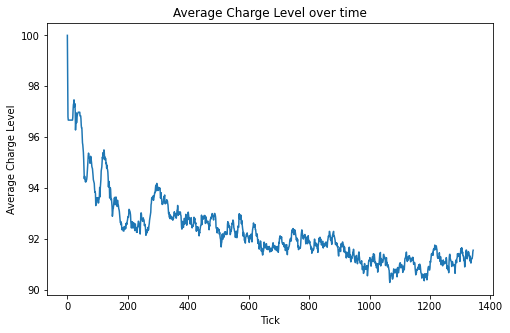

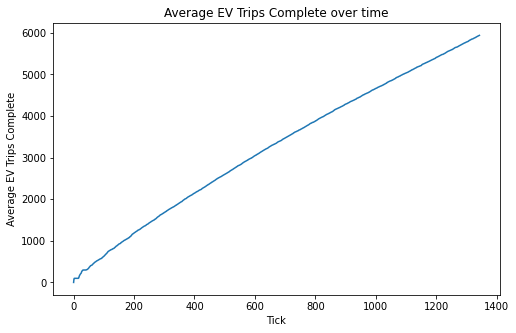

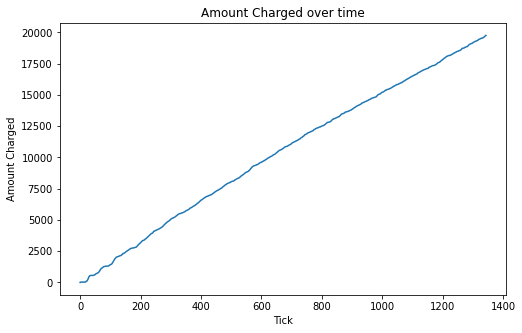

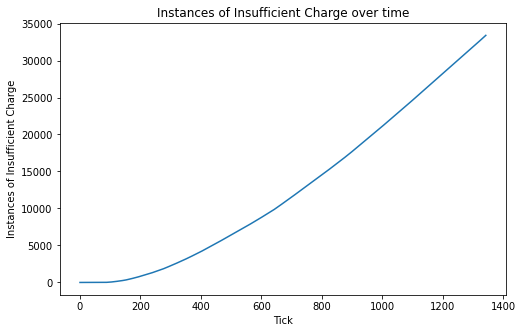

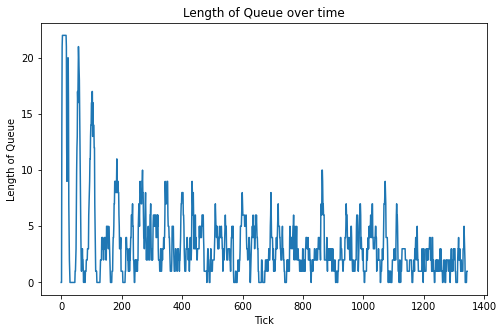

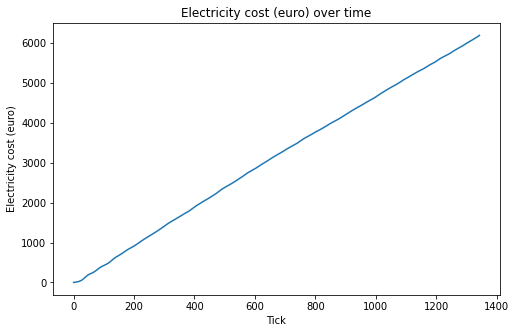

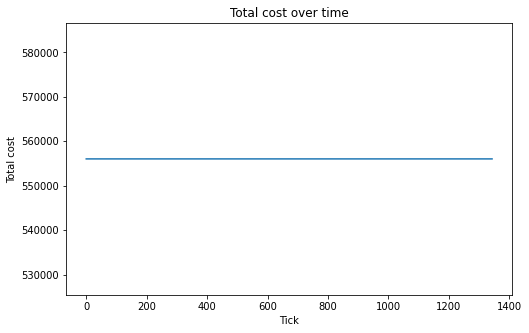

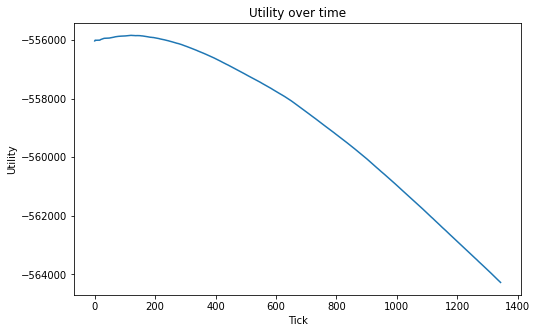

In [10]:
create_figures(data_collection)

In [11]:
print("MAXIMUM VALUES")
print(data_collection.max())
print("\n")
print("AVERAGE VALUES")
print(data_collection.mean())

MAXIMUM VALUES
Average Charge Level                   100.000000
Average EV Trips Complete             5940.000000
Amount Charged                       19771.209683
Instances of Insufficient Charge     33401.000000
Length of Queue                         22.000000
Electricity cost (euro)               6191.560898
Total cost                          556035.000000
Utility                            -555844.200000
dtype: float64


AVERAGE VALUES
Average Charge Level                    92.299206
Average EV Trips Complete             3238.930060
Amount Charged                       10345.202326
Instances of Insufficient Charge     12645.419643
Length of Queue                          3.375744
Electricity cost (euro)               3130.612179
Total cost                          556035.000000
Utility                            -558857.959598
dtype: float64
